In [66]:
from mortgage_calc.simulation import amortize_multi, RateOverPeriod as R
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

In [67]:
house = 375_000
down_payment = house*0.1
MORTGAGE = house - down_payment
print(MORTGAGE)
LOAN_TERM = 25*12
print(LOAN_TERM)

337500.0
300


In [79]:
class MultiSim:
    def __init__(self):
        self.cases = {}

    def add(self, name, rates):
        schedule = amortize_multi(
            MORTGAGE,
            LOAN_TERM,
            rates,
            extrapolate=False,
        )
        self.cases[name] = (rates, schedule)

    def plot(self):
        fig = plt.figure(figsize=(10, 10), layout="constrained")
        # https://matplotlib.org/stable/gallery/text_labels_and_annotations/figlegend_demo.html
        ax_rates, ax_payments = fig.subplots(2, 1, sharex=True)
        ax_rates.set_ylabel("rate (%)")
        ax_rates.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
        ax_payments.set_ylabel("payment ($)")
        ax_payments.yaxis.set_major_locator(ticker.MultipleLocator(50))


        # Used to display a single legend
        lines = []
        for case_name, (rates, schedule) in self.cases.items():
            rates_flat = []
            for rate_annual, months in rates:
                rates_flat += [rate_annual] * months
            line, *_ = ax_rates.plot(np.arange(1, len(rates_flat) + 1), rates_flat, label=case_name)
            lines.append(line)

            payments = [s.payment for s in schedule]
            ax_payments.plot(np.arange(1, len(schedule) + 1), payments, label=case_name)

        fig.legend(lines, self.cases.keys(), loc="outside right center")

    def summarize(self):
        case_names = self.cases.keys()
        totals = np.array([np.sum([s.payment for s in schedule]) for (_, schedule) in self.cases.values()])
        total_lowest = np.min(totals)
        ratios = totals / total_lowest
        df = pd.DataFrame({"name": case_names, "total": totals, "ratio": ratios})
        return df.sort_values("total")

In [80]:
m = MultiSim()
m.add(
    "5fix",
    [R(5.34, 5*12)],
)
m.add(
    "3fix + wowa_var",
    [R(5.94, 3*12), R(4.4, 6), R(4.15, 6), R(3.9, 6), R(3.9, 6)],

)
m.add(
    "3fix + perch_var",
    [R(5.94, 3*12), R(4.74, 6), R(4.4, 6), R(4.05, 6), R(4.27, 6)],
)
m.add(
    "var1",
    [R(r, 6) for r in (5.9, 5.9, 5.4, 4.9, 4.65, 4.4, 4.15, 3.9, 3.9, 4.15)],
)
m.add(
    "var2",
    [R(r, 6) for r in (5.9, 6.1, 5.9, 5.4, 4.9, 4.65, 4.4, 4.15, 3.9, 3.9)]
)
m.add(
    "var3",
    [R(r, 6) for r in (5.9, 6.1, 6.1, 5.9, 5.4, 4.9, 4.65, 4.4, 4.15, 3.9)]
)

In [81]:
df = m.summarize()
df

,name,total,ratio
3,var1,115437.36,1.000000
4,var2,117792.60,1.020403
5,var3,120312.54,1.042232
1,3fix + wowa_var,121073.58,1.048825
0,5fix,121725.00,1.054468
2,3fix + perch_var,122204.04,1.058618


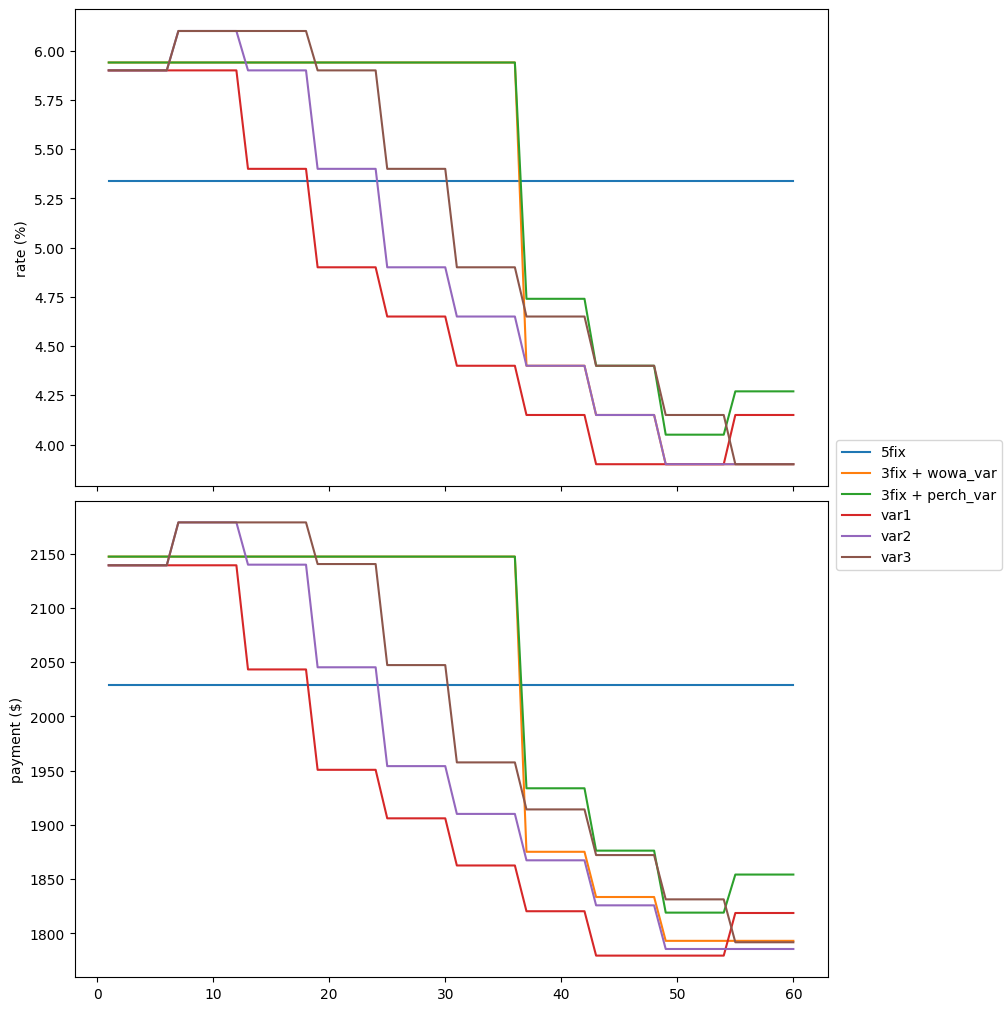

In [82]:
m.plot()